In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/medical-scan-classification-dataset/Covid/Covid'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/medical-scan-classification-dataset/Covid/Covid/CT Scan/Healthy/Non-COVID-19_116.png
/kaggle/input/medical-scan-classification-dataset/Covid/Covid/CT Scan/Healthy/65%4.jpg
/kaggle/input/medical-scan-classification-dataset/Covid/Covid/CT Scan/Healthy/54%1.jpg
/kaggle/input/medical-scan-classification-dataset/Covid/Covid/CT Scan/Healthy/Non-Covid (1153).png
/kaggle/input/medical-scan-classification-dataset/Covid/Covid/CT Scan/Healthy/Non-COVID-19_219.png
/kaggle/input/medical-scan-classification-dataset/Covid/Covid/CT Scan/Healthy/Non-Covid (352).png
/kaggle/input/medical-scan-classification-dataset/Covid/Covid/CT Scan/Healthy/Non-Covid (179).png
/kaggle/input/medical-scan-classification-dataset/Covid/Covid/CT Scan/Healthy/Non-Covid (672).png
/kaggle/input/medical-scan-classification-dataset/Covid/Covid/CT Scan/Healthy/Non-COVID-19_032.png
/kaggle/input/medical-scan-classification-dataset/Covid/Covid/CT Scan/Healthy/Non-COVID-19_838.png
/kaggle/input/medical-scan-classifica

In [2]:
import tensorflow as tf

# Define image size and batch size
image_size = (224, 224)
batch_size = 32

# Define data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2)
])

def augment(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = data_augmentation(image)
    return image, label

# Load dataset using image_dataset_from_directory
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/kaggle/input/medical-scan-classification-dataset/Covid/Covid/CT Scan',
    validation_split=0.2,
    subset='training',
    seed=111,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/kaggle/input/medical-scan-classification-dataset/Covid/Covid/CT Scan',
    validation_split=0.2,
    subset='validation',
    seed=111,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/kaggle/input/medical-scan-classification-dataset/Covid/Covid/CT Scan',
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

print(train_dataset.class_names)
# Apply augmentation
train_dataset = train_dataset.map(augment)
validation_dataset = validation_dataset.map(augment)
test_dataset = test_dataset.map(augment)

Found 12521 files belonging to 2 classes.
Using 10017 files for training.
Found 12521 files belonging to 2 classes.
Using 2504 files for validation.
Found 12521 files belonging to 2 classes.
['Disease', 'Healthy']


In [3]:
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D


# Load the pre-trained ResNet152 model without the top (classification) layers
base_model = ResNet152(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Print the model summary to see the layers
base_model.summary()

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

# Define the complete model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the summary of the complete model
model.summary()

234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "resnet152"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 58,370,944 (222.67 MB)

 Trainable params: 58,219,520 (222.09 MB)

 Non-trainable params: 151,424 (591.50 KB)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 61,520,770 (234.68 MB)

 Trainable params: 61,369,346 (234.11 MB)

 Non-trainable params: 151,424 (591.50 KB)

In [4]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(train_dataset, epochs=3, validation_data=validation_dataset, callbacks=[early_stopping])

Epoch 1/3


I0000 00:00:1731149111.344574      99 service.cc:145] XLA service 0x7ecd7c1d36d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731149111.344635      99 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1731149111.344641      99 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1731149197.178918      99 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_78', 16 bytes spill stores, 16 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_76', 16 bytes spill stores, 16 bytes spill loads

I0000 00:00:1731149197.282437      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


313/314 ━━━━━━━━━━━━━━━━━━━━ 0s 722ms/step - accuracy: 0.9077 - loss: 0.2273

I0000 00:00:1731149491.225588      99 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_63', 16 bytes spill stores, 16 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_65', 16 bytes spill stores, 16 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_64', 16 bytes spill stores, 16 bytes spill loads



314/314 ━━━━━━━━━━━━━━━━━━━━ 532s 1s/step - accuracy: 0.9079 - loss: 0.2269 - val_accuracy: 0.8299 - val_loss: 0.4061
Epoch 2/3
314/314 ━━━━━━━━━━━━━━━━━━━━ 270s 859ms/step - accuracy: 0.9606 - loss: 0.1158 - val_accuracy: 0.9744 - val_loss: 0.0839
Epoch 3/3
314/314 ━━━━━━━━━━━━━━━━━━━━ 270s 859ms/step - accuracy: 0.9653 - loss: 0.0961 - val_accuracy: 0.9700 - val_loss: 0.0825


In [5]:
model.evaluate(test_dataset)

392/392 ━━━━━━━━━━━━━━━━━━━━ 206s 526ms/step - accuracy: 0.9678 - loss: 0.0918


[0.08943304419517517, 0.9690919518470764]

In [6]:
model.save("ResNet152.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1


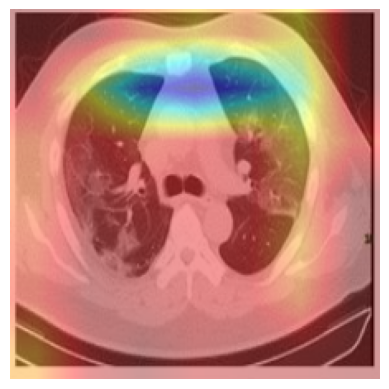

In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load the pre-trained model
model = load_model('/kaggle/working/ResNet152.keras')  # Make sure the model path is correct

# Function to generate Grad-CAM heatmap using tf.GradientTape
def generate_grad_cam(model, img_array, last_conv_layer_name="conv5_block3_out", pred_index=None):
    """
    Generate Grad-CAM heatmap for a model using tf.GradientTape.
    Args:
        model: The Keras model.
        img_array: Preprocessed image input to the model.
        last_conv_layer_name: The name of the last convolutional layer.
        pred_index: The index of the class to explain (if None, takes the model's top prediction).

    Returns:
        Heatmap of Grad-CAM.
    """
    # Convert the image array to a tensor if it isn't one
    img_array = tf.convert_to_tensor(img_array, dtype=tf.float32)

    # Create a sub-model that goes from the model's input to the last convolutional layer's output
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_model = tf.keras.Model(model.inputs, last_conv_layer.output)

    # Create another sub-model that goes from the output of the last conv layer to the model's final output
    classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer in model.layers[model.layers.index(last_conv_layer) + 1:]:
        x = layer(x)
    classifier_model = tf.keras.Model(classifier_input, x)

    # Run a forward pass with GradientTape to record operations
    with tf.GradientTape() as tape:
        # Compute activations of the last convolutional layer
        last_conv_layer_output = last_conv_model(img_array)
        tape.watch(last_conv_layer_output)

        # Compute predictions
        predictions = classifier_model(last_conv_layer_output)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])  # Get the index of the top prediction
        class_output = predictions[:, pred_index]  # Class score for the predicted class

    # Calculate the gradients of the top predicted class with respect to the activations of the last conv layer
    grads = tape.gradient(class_output, last_conv_layer_output)

    # Calculate the channel-wise mean of the gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map array by the pooled gradients
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap to range [0, 1] for visualization
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

    return heatmap

# Function to overlay the heatmap on the image
def overlay_heatmap(heatmap, img_path, alpha=0.4):
    """
    Overlay the Grad-CAM heatmap on top of the original image.
    Args:
        heatmap: The Grad-CAM heatmap to overlay.
        img_path: Path to the original image.
        alpha: Transparency factor for overlay.

    Returns:
        None
    """
    img = cv2.imread(img_path)  # Load the image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for plotting
    img = cv2.resize(img, (224, 224))  # Resize to match the input size expected by the model

    # Resize the heatmap to match the image size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Convert the heatmap to a color map (e.g., jet colormap)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Combine the heatmap with the image
    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)

    # Plot the result
    plt.imshow(superimposed_img)
    plt.axis('off')  # Hide axes
    plt.show()

# Example: Load a sample image to explain (replace with an actual test image)
img_path = '/kaggle/input/medical-scan-classification-dataset/Covid/Covid/CT Scan/Disease/2020.02.10.20021584-p6-52%1.png'  # Path to the image you want to explain

# Preprocess the image as per the model's input requirements
img = image.load_img(img_path, target_size=(224, 224))  # Adjust size as needed
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Normalize if required by your model

# Get the top prediction (this can be a lung cancer classification)
predictions = model.predict(img_array)
pred_index = np.argmax(predictions[0])  # Get the index of the predicted class
print(pred_index)

# Generate Grad-CAM heatmap
heatmap = generate_grad_cam(model, img_array)

# Overlay the heatmap on the original image
overlay_heatmap(heatmap, img_path)
